In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

from IPython.display import HTML

import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
matplotlib.rc("font", family="serif", size=14)
matplotlib.rc("figure", figsize="10, 5")
colors = ['k', 'c', 'm', 'y']
matplotlib.rc('axes', prop_cycle=cycler("color", colors))

import numpy as np
import healpy as hp
import pandas as pd

**Requirements**:
- `Anaconda`:
    - `scipy`
    - `numpy`
    - `matpltlib`
    - `pandas`
- `healpy`: 
```bash
pip install healpy` or `conda install healpy
```
- `astropy`: 
```bash
pip install --no-deps astropy
```

# WISE-2MASS MAP (Wide-field Infrared Survey Explorer (WISE))
Paper (arxiv:1401.0156): `Star-galaxy separation strategies for WISE-2MASS all-sky infrared galaxy catalogs`

- In this tutorial, we will use the WISE catalogue we got from the `irsa` website to make a Galaxy Count Map on `Healpix` grid with `healpy` (python module for `Healpix`).
- In the original paper, they used SVM to train a classifier to separate the galaxy objects from star objects in the catalogue. Let's skip the step of training SVM, just apply the query provided by them. They argued the result of this query is empirically almost the same as the training result.
<img src="cut-star-gal-sep.png" alt="Drawing" style="width: 600px;"/>

You can: 
1. go to this page: http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-scan?mission=irsa&submit=Select&projshort=WISE,  
2. select `WISE All-Sky Source Catalog`,  
3. enter your query:
```
w1mpro between 12.0 and 15.2 and 
n_2mass > 0 and
w1mpro - j_m_2mass < -1.7 and 
glat not between -10 and 10
```
4. download the `.tbl` file (`~2G`, you can try it after Astrotalk.)

In [3]:
# where you can download the WISE-all sky source catalogue
from IPython.display import IFrame
IFrame('http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-scan?mission=irsa&submit=Select&projshort=WISE',
       width='100%', height=300)

In [4]:
# the description for the catalogue
from IPython.display import IFrame
IFrame('http://wise2.ipac.caltech.edu/docs/release/allwise/expsup/sec2_1a.html#w1mpro',
       width='100%', height=300)

## Generate Catalog from Website
- After successfully generate the catalog, you will see this page
![](cut-wise-result.png)
- download the output ipac `.tbl` file (around 2GB)
- Around 4,915,596 objects


if you don't want to download the whole data from the web, I provide a [`short version`](https://drive.google.com/open?id=0B7r6Q4zhyLuaczFNQ0M3T2lWSjg). It only contain `ra`, `dec`, `j_m_2mass` columns.

In [17]:
# read dataframe if you don't have tbl data
df = pd.read_csv('wise-2mass-short.csv')
df.tail()

,ra,dec,j_m_2mass
4915591,171.608329,29.710292,14.988
4915592,171.630791,29.704484,16.944
4915593,171.657546,29.492600,16.073
4915594,171.690979,29.613465,17.027
4915595,171.488352,29.617523,16.769


## Read the `.tbl` data line by line

If you download the whole data (`.tbl`) from web, use the following cells to generate the dataframe.

In [4]:
# human readable size calculate function 
# https://stackoverflow.com/questions/1094841/reusable-library-to-get-human-readable-version-of-file-size
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return ("%3.1f%s%s" % (num, unit, suffix))
        num /= 1024.0
    return ("%.1f%s%s" % (num, 'Yi', suffix))

In [7]:
import sys

# initialize with empty ndarray
ra  = np.empty(4915596)
dec = np.empty(4915596)
j_m_2mass = np.empty(4915596)

filename = "wise_allsky.allsky_4band_p3as_psd19970.tbl"

# counter
count = 0
with open(filename,'r') as datafile:
    while 1:
        # read line by line to save the memory
        line = datafile.readline()
        if not line: break
        
        # tokenize the line into list 
        items = line.split()
        
        # skip the comments
        if (items[0][0] == '\\'):
            continue
            
        # only store the entries we want
        elif (items[0][0] != '|' and items[0][0] != '\\'):
            ra[count] = float(items[1])
            dec[count] = float(items[2])
            j_m_2mass[count] = float(items[-6])
            
            # counting the index
            count += 1

# making pandas dataframe
df = pd.DataFrame([ra, dec, j_m_2mass]).T
df.columns = ['ra', 'dec', 'j_m_2mass']

# delete the memory of them
del ra, dec, j_m_2mass

print ('The size of this dataframe is {}'.format(sizeof_fmt(sys.getsizeof(df))))

The size of this dataframe is 112.5MiB


## Cut J Band with J < 16.5
- Argue in the article, J cut with J < 16.5 get a homogeneous result.
- This step is quite empirical. They just found out that J > 16.5 are highly affected by spatial variations in 2MASS.

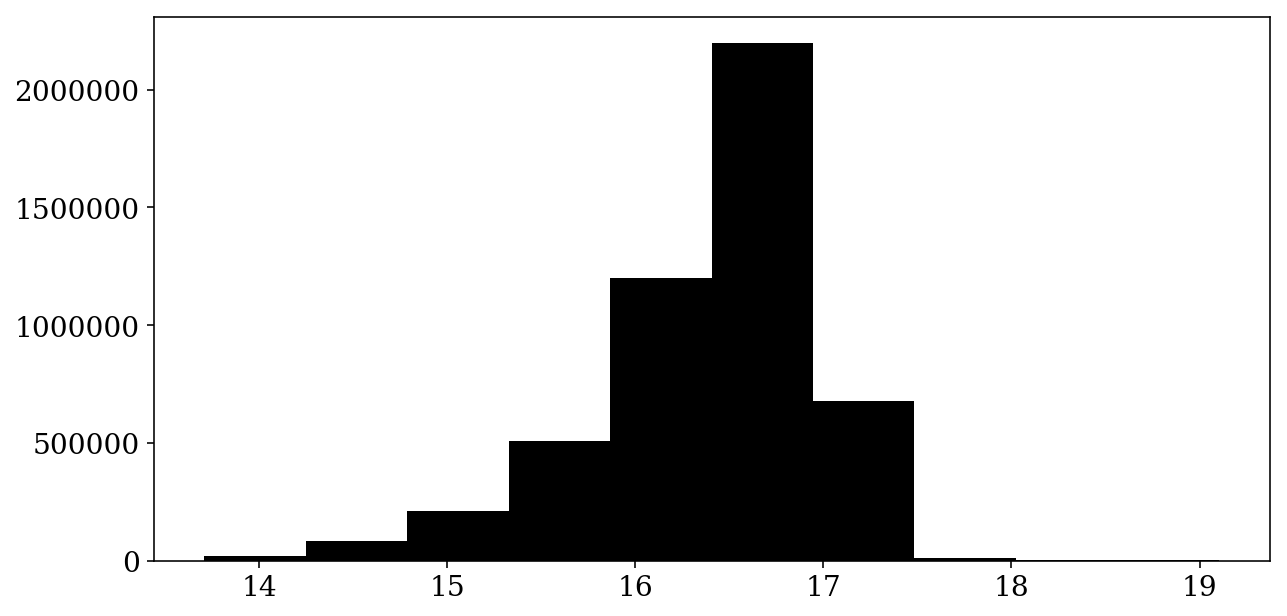

In [3]:
# visualize the distribution of J band
plt.hist(df.j_m_2mass);

## Coordinate conversion: RA,DEC -> glon, glat
- The catalog only provide coordinates in ra,dec unit,
- I use a lazy way to convert the coordinate: use `Astropy`'s `SkyCoord`

<img src="https://upload.wikimedia.org/wikipedia/commons/9/98/Ra_and_dec_on_celestial_sphere.png" alt="Drawing" style="width: 600px;"/>

In [4]:
# generate a blank healpix array for appending 
healpix = np.zeros(hp.nside2npix(128))
print ('size of healpix grids {}:'.format(healpix.shape))

size of healpix grids (196608,):


The result of appending objects with `ra`, `dec` on `Healpix`.

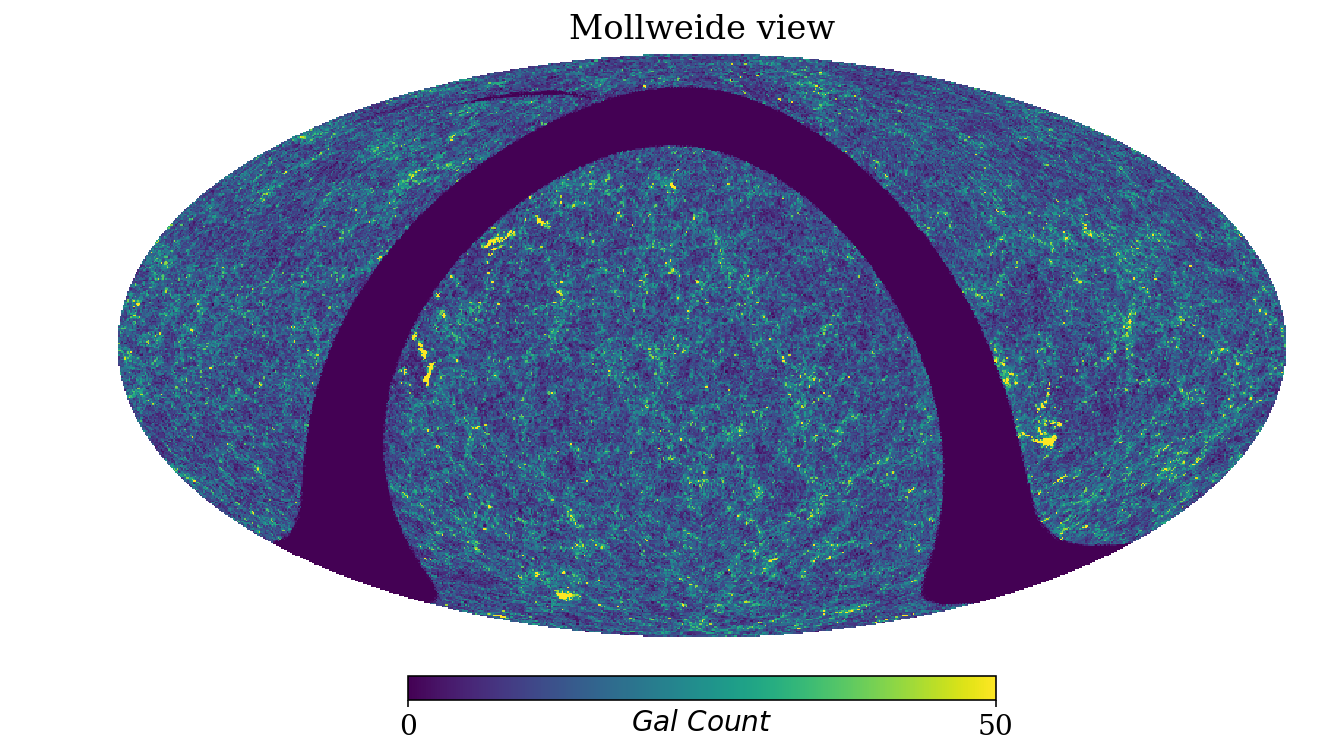

In [7]:
# What you will get if you directly use ra dec to stack the histogram
nside = 128
healpix_wrong = np.zeros(hp.nside2npix(nside))

# select J < 16.5 mag
idx = np.array(df.j_m_2mass < 16.5)
ra  = df.ra.values[idx]
dec = df.dec.values[idx]
phi   = ra * np.pi / 180
theta = (90 - dec) * np.pi / 180

# add back to the healpix grids
ipix = hp.ang2pix(nside, theta=theta, phi=phi, lonlat=0)
for pix in ipix:
    healpix_wrong[pix] += 1

hp.mollview(healpix_wrong, unit='$Gal$ $Count$', max=50, )

Use galactic Coor

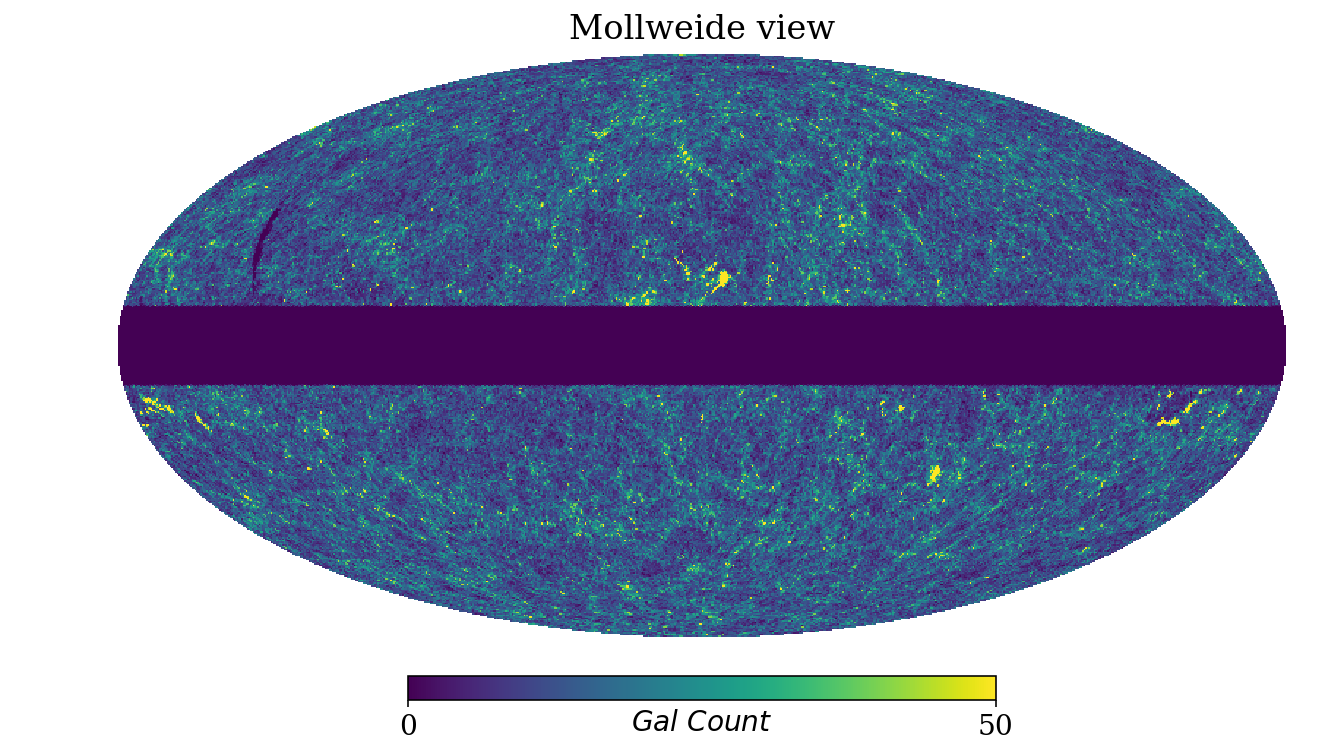

In [5]:
# convert ra,dec to glon,glat
# we are lazy men, let's use astropy's Skycoord to convert
from astropy.coordinates import SkyCoord
from astropy import units as u

def eq2gal(ra, dec):
    c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    l,b = c.galactic.l.deg, c.galactic.b.deg
    return l, b

nside = 128
healpix = np.zeros(hp.nside2npix(nside))

# convert to gal coor
l,b = eq2gal(df.ra, df.dec)

# select J < 16.5 mag
idx = np.array(df.j_m_2mass < 16.5)
l = l[idx]
b = b[idx]
phi   = l * np.pi / 180
theta = (90 - b) * np.pi / 180

# add back to the healpix grids
ipix = hp.ang2pix(nside, theta=theta, phi=phi, lonlat=0)
for pix in ipix:
    healpix[pix] += 1

hp.mollview(healpix, unit='$Gal$ $Count$', max=50)

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


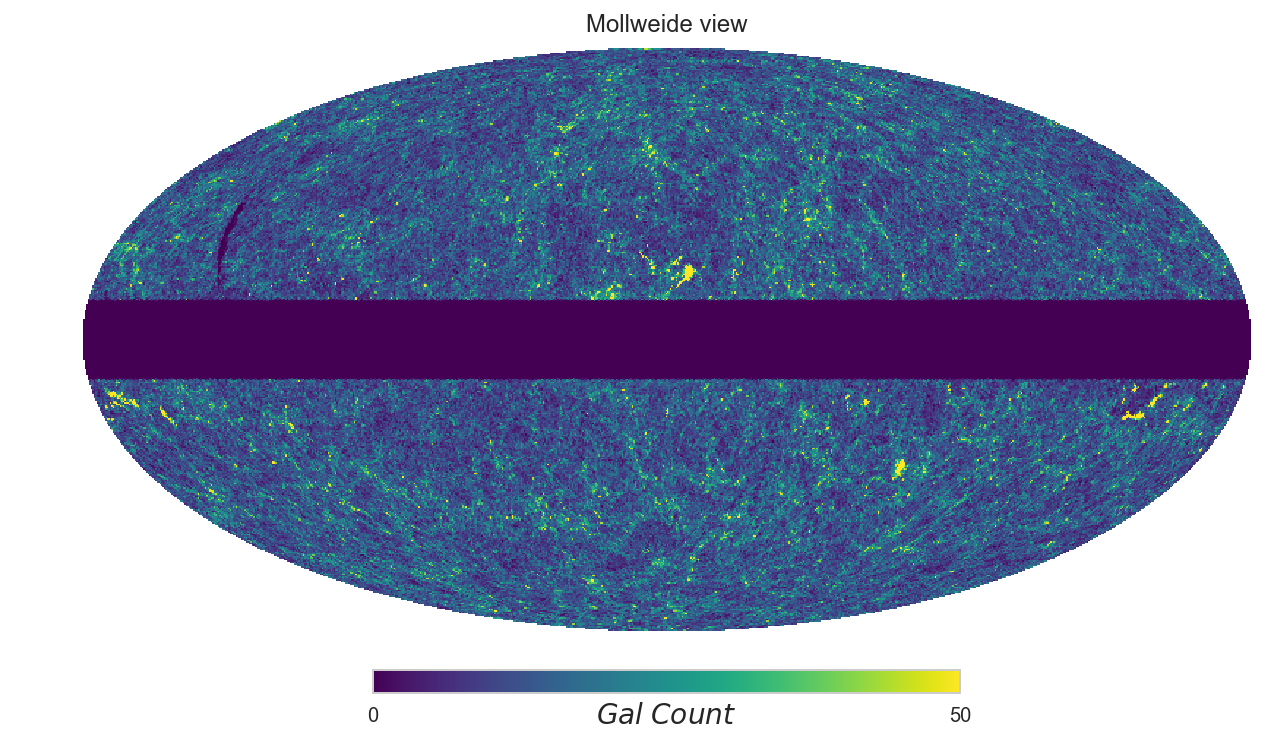

In [79]:
# Save the map, and read it
hp.write_map('wise-2mass-density-16.5-lb.fits', healpix)

healpix = hp.read_map('wise-2mass-density-16.5-lb.fits')
hp.mollview(healpix, cmap='viridis', max=50, unit='$Gal$ $Count$')

## Dust Map Generation
- metion in the article, they use dust map in Schlegel et al. (1998) with  `E(B − V ) >=  0.1`
    - The E(B-V) values from the map give information about the amplitude of dust extinction in a given direction. To get the extinction at a given wavelength or through a given filter, one needs information about the relative extinction between different wavelengths: an "extinction law".
- one way: use original data
- the other way: use WMAP produced Healpix format data (which I chose)

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


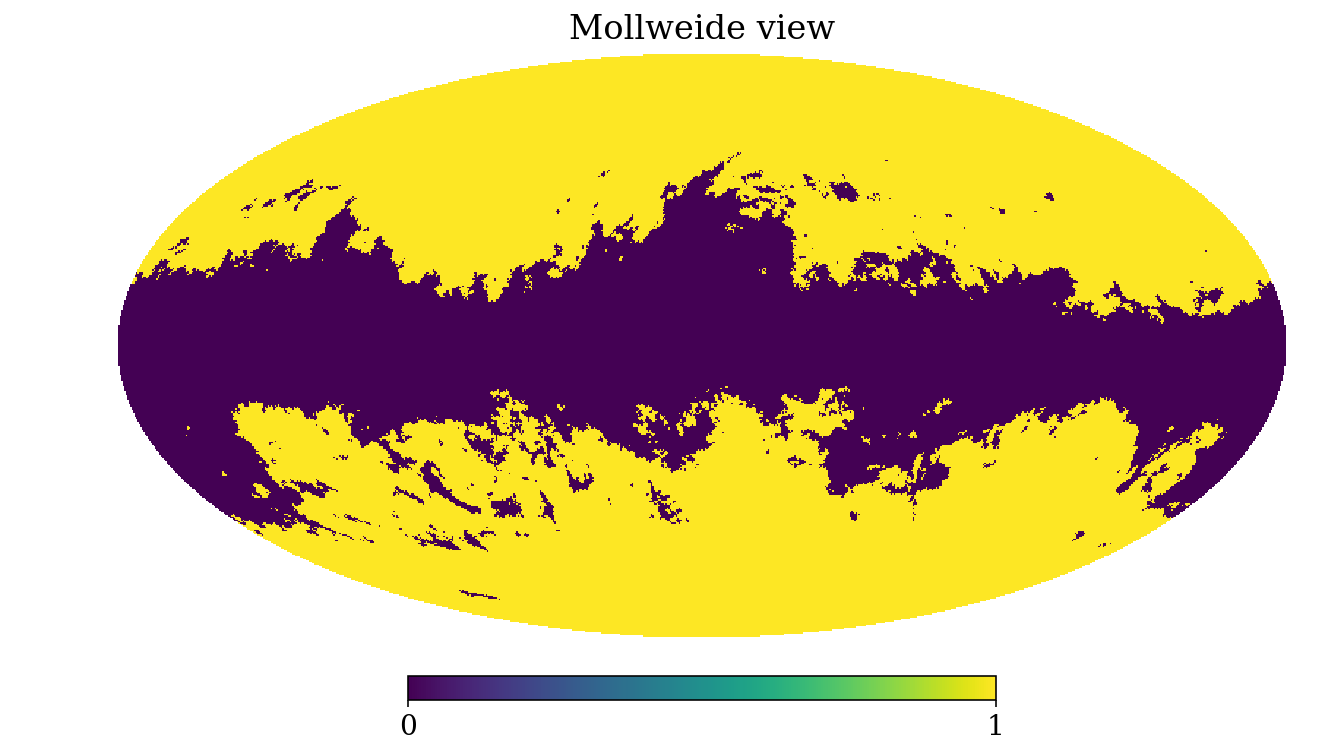

In [8]:
# directly read the dust map in Healpix Grids
dust = hp.read_map('sdf_nside_128.fits')
mask = np.ones(len(dust))
mask[dust >= 0.1] = 0
hp.mollview(mask)

## WISE-2MASS Map with Masking

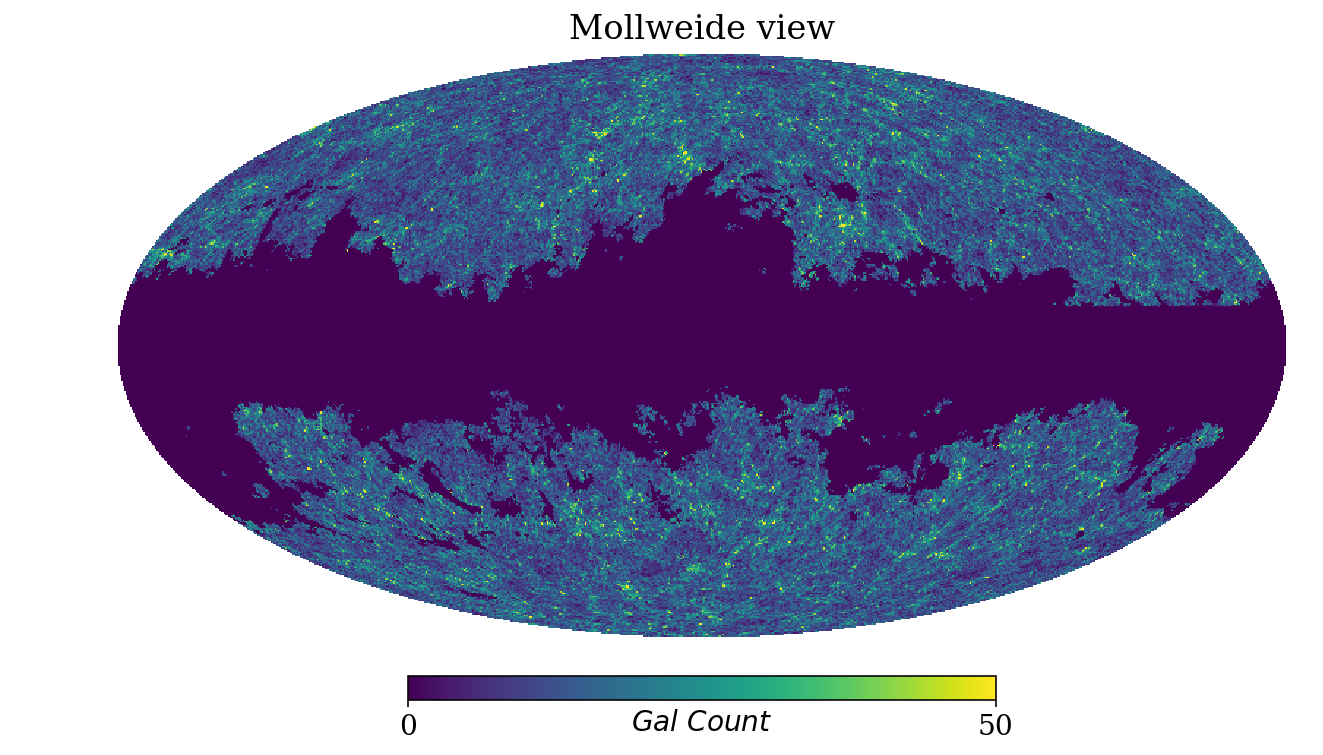

In [21]:
hp.mollview(healpix * mask, max=50, unit='$Gal$ $Count$')

## Smoothing with 1 deg sigma
- To make a better visualization of the matter distribution on the healpix, let's apply kernel on the histogram map.
- after kernel smoothing, we can see the voids in the matter distribution map.

Sigma is 60.000000 arcmin (0.017453 rad) 
-> fwhm is 141.289203 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


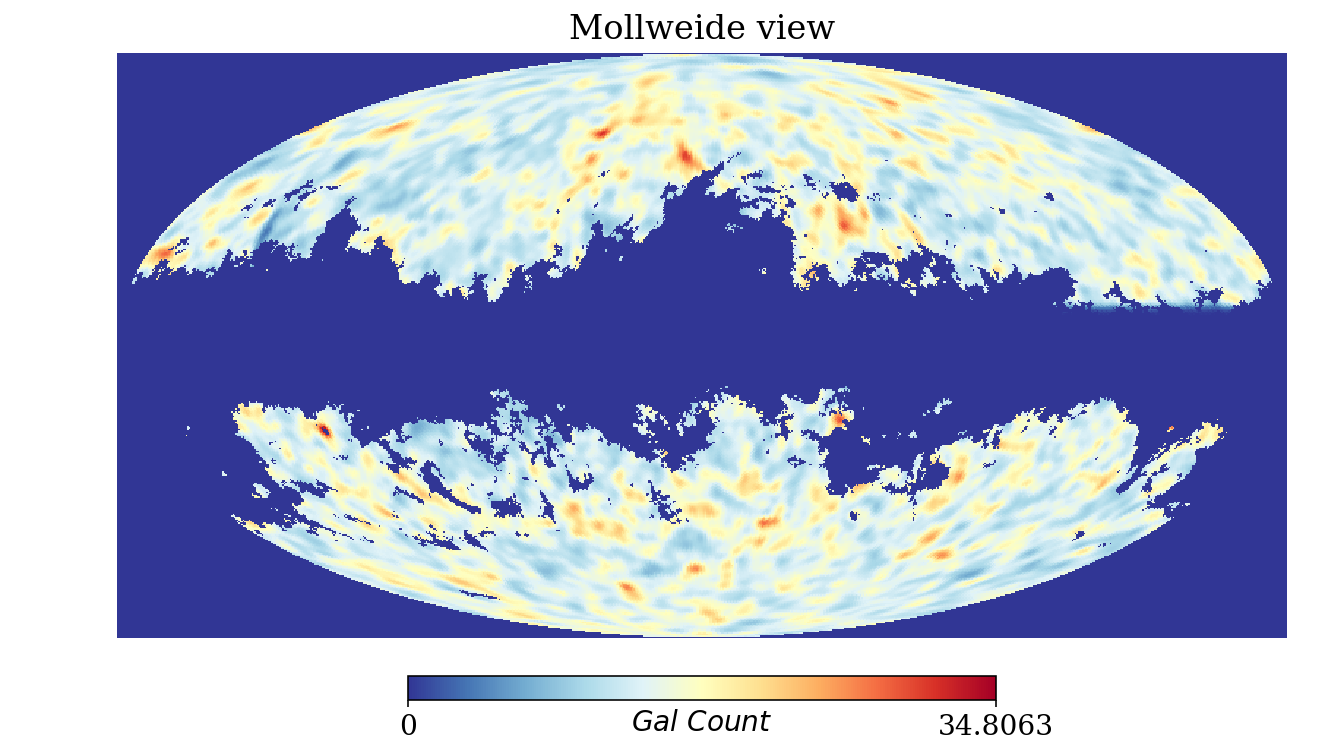

In [189]:
healpix_smooth = hp.smoothing(healpix, sigma=1 * np.pi / 180, )
hp.mollview(healpix_smooth * mask, cmap='RdYlBu_r', unit='$Gal$ $Count$') 

## Cartesian Projection in the Cold Spot Line-of-sight
- Let's try to see the large under dense regions in the cold spot line-of-sight they claimed in the paper.

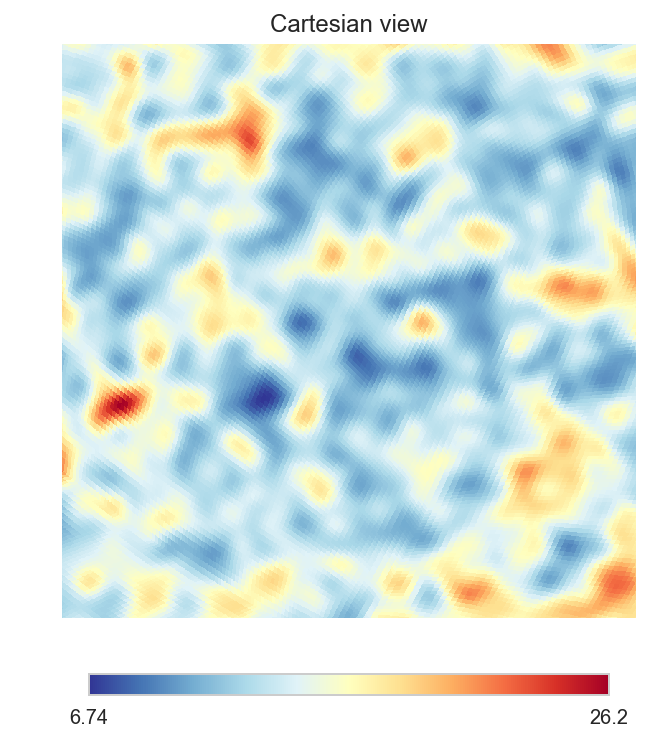

In [209]:
# use cartview function to project a square on a line of sight
hp.cartview(healpix_smooth, cmap='RdYlBu_r',
            rot=(207.8, -56.3), lonra=(-30, 30), latra=(-30, 30))